# Analysis of numbers and rates of tweets in English and Persian about Mirzakhani
Maryam Mirzakhani passed away on July 14 2017. The analysis below is performed on twitter data which was obtained using tweepy by collecting every tweet which contained her name between July 10 and Aug 10 2017. The data contains two sets, one in English and another Persian. The way they are categorized was by checking whether a tweet was found by searching Mirzakhani in English or Persian. There are tiny fractions of tweets which are mis-categorized due to this criterion, which will be ignored in this analysis. 

In [1]:
import pylab as plt
import matplotlib
import pandas as pd
import numpy as np

In [2]:
matplotlib.rcParams.update({'font.size': 14}) #increase the plots' font size 

Make a dictionary which relates the paths of the data files to the two platforms I use.

In [ ]:
path_dict = {'mac': "/Users/user/twitter/Mirzakhani/", 
             'pc': "C:\\Users\\user\\twitter\\Mirzakhani\\"} #I have removed my name

Read and aggregate the times of the tweets from files. The variable "lan" determines the language of tweets. The Function returns an increasing list of times of all tweets in seconds in UTC.

In [4]:
def find_tweet_vs_time(lan):
    try:
        time_df = pd.read_csv(path_dict['mac']+"time_"+lan+"-7_23-7_29.txt", sep=',', header = None, names = ['t'])
        plt = 'mac'
    except:
        time_df = pd.read_csv(path_dict['pc']+"time_"+lan+"-7_23-7_29.txt", sep=',', header = None, names = ['t'])
        plt = 'pc'

    filenames = [path_dict[plt]+"time_"+lan+"-8_04-8_10.txt", path_dict[plt]+"time_"+lan+"-7_30-8_03.txt", path_dict[plt]+"time_"+lan+"-7_23-7_29.txt", 
                 path_dict[plt]+"time_"+lan+"-7_18-7_22.txt", path_dict[plt]+"time_"+lan+"-7_10-7_17.txt", ]    
    months = {'Jul':7, 'Aug':8}
    months_len = {'Jul':31, 'Aug':31}
    
    t_list = []
    for fl in filenames:
        time_df = pd.read_csv(fl, sep=',', header = None, names = ['t'])        
        for index, row in time_df.iterrows():
            dates = str.split(row['t'], ' ') # looks like ['Tue', 'Jul', '18', '00:00:26', '+0000', '2017']
            mnth = (int(months[dates[1]]) - 7) * 31 * 24* 3600 #July is the month of origin
            day = 24* 3600* (int(dates[2]))
            ttt = str.split(dates[3],':')
            hr = 3600 * int(ttt[0])
            mt = 60 * int(ttt[1])
            sc = int(ttt[2])
            t_f = mnth + day + hr + mt + sc
            t_list.append(t_f)
    
    return np.asarray(t_list)[::-1] #files go from more recent to earlier tweets, so I reverse the order.

In [5]:
t_list_eng = find_tweet_vs_time('eng') #Time series of English tweets in seconds, UTC 
t_list_per = find_tweet_vs_time('per') #Time series of Persian tweets in seconds, UTC 

Converting both time series into day units and shifting them to PDT time zone. 

In [6]:
t_day_eng = t_list_eng/(24.*3600) - 7./24  # Time series of Eng tweets in continuous days units in PDT time.
t_day_per = t_list_per/(24.*3600) - 7./24  # Time series of Per tweets in continuous days units in PDT time.

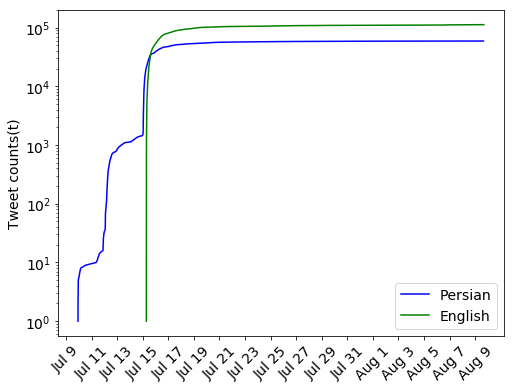

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(t_day_per,range(1,len(t_day_per)+1),'b-', label = 'Persian')
plt.plot(t_day_eng,range(1,len(t_day_eng)+1),'g-', label = 'English')
plt.legend()
plt.yscale('log')
plt.ylabel('Tweet counts(t)')
#plt.xlabel('Time (July days UTC)')
#plt.xticks(range(11,32,2))
days = range(9,42,2)
labels = ['Jul '+str(i) for i in range(9,32,2)]+['Aug '+str(i) for i in range(1,11,2)]
plt.xticks(days,labels,rotation = 45)
plt.show()

There are no English tweets before July 15. The Persian tweets between July 10th and 15th correspond to the rumors about Mirzakhani's sickness. The two rapid increases in the number of tweets likely correspond to the two waves of rumors spreading within social networks. Late at the night of the 14th, which is around noon of the 15th in Iran, and a bit later in the morning of 15th on the east coast, the rapid increase in both English and Persian tweets is observed, which correspond to the news about her passing. 

To study this better, it is best to derive the tweeting rate. Tweeting rate is essentially equal to $1/dt_{tweet}$. However, calculating it this way will not only produce a noisy result, but also will result in multiple divergences during peak tweeting times (when $dt_{tweet} = 0$ up to measurement precision, which is seconds). Instead, I use a smoothing method as follows. If $N_W$ is the total number of tweets, I divide the entire series into sets of N (=25) consecutive tweets. The starting tweet indeces of the sets will be therefore $0, N, 2N, ...$. For the $k$-th set, the indices will be $kN ... (k+1)N$, and $\delta t = t_{(k+1)N} - t_{kN}$. The tweeting rate is thus $N/\delta t$. To take into account all the tweets in between, then, I move the starting point to form a shifted set with the same length, i.e. with indices $kN+i ... (k+1)N+i$ and repeat this for all $0<i<N$. I finally assign the average tweeting rate obtained by averaging $N/\delta t$ for all N sets to $t = t_{(k+1)N}$.

In [8]:
def find_tweet_rate(t_list_X):
    N = 25 # smoothing number
    rdc_len = len(t_list_X)/N - 1# length of the subsampled array+1
    for i in range(N):
        if i == 0:
            rate = N* 1./np.diff(t_list_X[i: rdc_len * N : N])
        else:
            rate = rate + N* 1./np.diff(t_list_X[i: rdc_len * N : N])
    rate = rate / (1.*N)
    return rate, rdc_len, N

In [9]:
rate_per, len_per, N = find_tweet_rate(t_day_per)
rate_eng, len_eng, N = find_tweet_rate(t_day_eng)
t_binned_per = t_day_per[N: len_per * N : N] # time lists with bins of size N, shifted to july 10 and in days units
t_binned_eng = t_day_eng[N: len_eng * N : N]

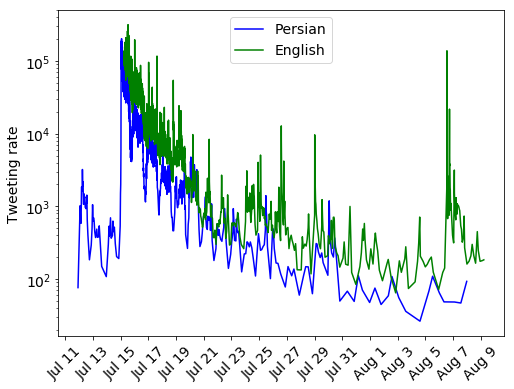

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(t_binned_per, rate_per,'b-', label = 'Persian')
plt.plot(t_binned_eng, rate_eng,'g-', label = 'English')
plt.legend()
plt.yscale('log')
plt.ylabel('Tweeting rate')
#plt.xlabel('Time (July days UTC)')
days = range(11,42,2)
labels = ['Jul '+str(i) for i in range(11,32,2)]+['Aug '+str(i) for i in range(1,11,2)]
plt.xticks(days,labels,rotation = 45)
plt.show()

There is a visible oscillation in Persian tweet rates, which syncs well with day/night cycles, indicating that a majority of Persian tweets are coming from within Iran, and showing that those tweets were not dominated by the considerable number of Iranians who live outside Iran and within the US. The oscillations are much less pronounced, especially in the first few days, showing that English tweets are more spread around the world, as expected.

There looks to be a power-law decay of tweet-rates after Mirzakhani's passing (see below). There are several spikes in tweet rates which correspond to a few events and publications. There are a couple of publications by the American Mathematical Society and Aljazeera on July 24; on July 25, Marina Ratner, an extremely influential female Russian mathematician also passes away; on July 29 there is a Guardian piece on Mirzakhani, and on Aug 7 there is a highly cited piece in NY Times on Mirzakhani and Ratner.  

In Persian news, on July 25th a short article responded to a dismissive and disrespectful earlier article about Mirzakhani and her work (sigh); on July 30th, Tehran's City Council fast-tracked a legislation to name a street or passage in Tehran after Mirzakhani. 

### Tweet rates' decay form after Mirzakhani's passing
I define the "event" (death) time in two ways: 

1) time at which Persian tweeting rate is maximum,

2) time when English tweets begin.

I start with 1:

In [11]:
event_index = np.argmax(rate_per)
event_time = t_day_per[event_index * N]
print event_time

15.0724652778


In [12]:
t_after_per = filter(lambda x: x > event_time, t_binned_per) # binned time points after the event
rate_after_per = rate_per[len(t_binned_per)-len(t_after_per):] # rates corresponding to the time points after the event
len(t_after_per) == len(rate_after_per)

True

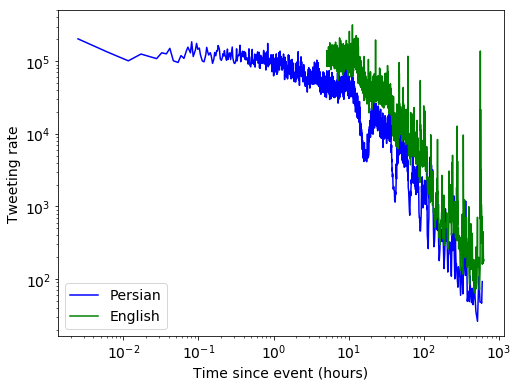

In [13]:
plt.figure(figsize=(8, 6))
plt.plot((t_after_per - event_time)*24, rate_after_per,'b-', label = 'Persian')
plt.plot((t_binned_eng - event_time)*24, rate_eng,'g-', label = 'English')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tweeting rate')
plt.xlabel('Time since event (hours)')
plt.show()

2nd definition:

In [14]:
event_time_2 = t_day_eng[0]
print event_time_2

15.2845717593


In [15]:
t_after_per_2 = filter(lambda x: x > event_time_2, t_binned_per) # binned time points after the event
rate_after_per_2 = rate_per[len(t_binned_per)-len(t_after_per_2):] # rates corresponding to the time points after the event
len(t_after_per_2) == len(rate_after_per_2)

True

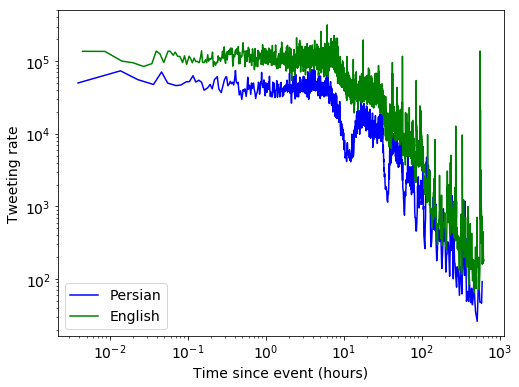

In [16]:
plt.figure(figsize=(8, 6))
plt.plot((t_after_per_2 - event_time_2)*24, rate_after_per_2,'b-', label = 'Persian')
plt.plot((t_binned_eng - event_time_2)*24, rate_eng,'g-', label = 'English')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tweeting rate')
plt.xlabel('Time since event (hours)')
plt.show()

There are no significant differences between the two definitions of the "event" time. Obviously, a power-law form (with a negative power) will only apply to the long-term behavior of the rate, as for short times the rate remains finite. So below I fit the curves with a power-law:

In [17]:
from scipy.optimize import curve_fit

In [18]:
def power_fit(t,p,A):
    return A* t**p

In [19]:
cutoff = 5
t_cut_per = filter(lambda x: x > cutoff, (t_after_per_2 - event_time_2)*24)
t_cut_eng = filter(lambda x: x > cutoff, (t_binned_eng - event_time_2)*24)
low_cut_per = len(rate_after_per_2) - len(t_cut_per)
low_cut_eng = len(rate_eng) - len(t_cut_eng)
per_popt, per_cov = curve_fit(power_fit, t_cut_per, rate_after_per_2[low_cut_per:])
eng_popt, eng_cov = curve_fit(power_fit, t_cut_eng, rate_eng[low_cut_eng:])
print 'Per_pow = %.3f' % per_popt[0],'+_ %.3f' % np.sqrt(np.diag(per_cov))[0]
print 'Eng_pow = %.3f' % eng_popt[0],'+_ %.3f' % np.sqrt(np.diag(eng_cov))[0]

Per_pow = -0.960 +_ 0.017
Eng_pow = -0.907 +_ 0.010


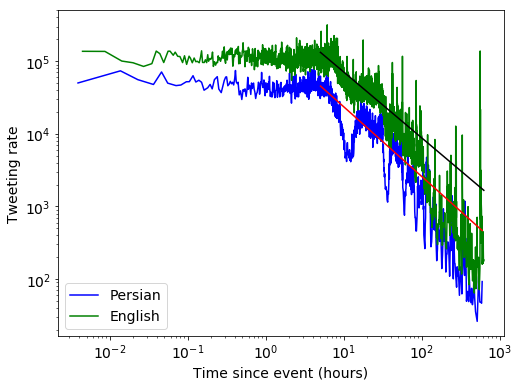

In [20]:
plt.figure(figsize=(8, 6))
plt.plot((t_after_per_2 - event_time_2)*24, rate_after_per_2,'b-', label = 'Persian')
plt.plot((t_binned_eng - event_time_2)*24, rate_eng,'g-', label = 'English')
plt.plot(t_cut_per, power_fit(t_cut_per, *per_popt),'r-')
plt.plot(t_cut_eng, power_fit(t_cut_eng, *eng_popt),'k-')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tweeting rate')
plt.xlabel('Time since event (hours)')
plt.show()

This fit is dominated by the spikes. To make the fit follow the overall trend, we should fit a line to the logarithms of the data directly: 

In [21]:
def linear_fit(t,sl,b):
    return sl*t + b

In [22]:
per_lin_popt, per_lin_cov = curve_fit(linear_fit, np.log(t_cut_per), np.log(rate_after_per_2[low_cut_per:]))
eng_lin_popt, eng_lin_cov = curve_fit(linear_fit, np.log(t_cut_eng), np.log(rate_eng[low_cut_eng:]))
print 'Per_pow = %.3f' % per_lin_popt[0],'+_ %.3f' % np.sqrt(np.diag(per_lin_cov))[0]
print 'Eng_pow = %.3f' % eng_lin_popt[0],'+_ %.3f' % np.sqrt(np.diag(eng_lin_cov))[0]

Per_pow = -1.241 +_ 0.015
Eng_pow = -1.229 +_ 0.008


This of course is an underestimation of the errors, since the fit assumes all tweets to be independent events. Many tweets, however are either retweets or the same people tweeting again, which are not independent events. As a result, the statement I can make is that the power with which tweeting rate decays is a number close to -1. 

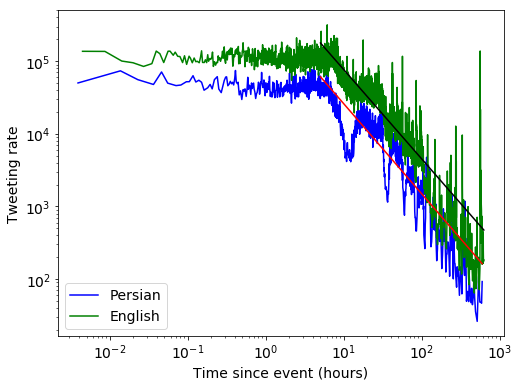

In [23]:
plt.figure(figsize=(8, 6))
plt.plot((t_after_per_2 - event_time_2)*24, rate_after_per_2,'b-', label = 'Persian')
plt.plot((t_binned_eng - event_time_2)*24, rate_eng,'g-', label = 'English')
plt.plot(t_cut_per, power_fit(t_cut_per, per_lin_popt[0], np.exp(per_lin_popt[1])),'r-')
plt.plot(t_cut_eng, power_fit(t_cut_eng, eng_lin_popt[0], np.exp(eng_lin_popt[1])),'k-')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tweeting rate')
plt.xlabel('Time since event (hours)')
plt.show()